<h1 style="display: flex; align-items: center;">
    <img src="../assets/icons/icons8-comparison-48.png" style="width: 50px; height: 50px; margin-right: 10px;">
    <strong>Results and Comparisons</strong>
</h1>

In [1]:
%cd ..

c:\Dor\TECHNION\deep_learning\Project\MRI_Barin_Alzheimer_Classification


<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-import-64.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Imports
</h1>


In [2]:
# Suppress user and future warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# imports
import sys
import os
import numpy as np
import pandas as pd
import torch
from torchsummary import summary
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Subset, ConcatDataset
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from kornia import augmentation as K
from kornia.augmentation import AugmentationSequential
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import random
import time
from datetime import datetime
import json


# repository imports
from models import def_models
from utils import utils_funcs

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-gpu-64.png" style="width: 40px; height: 40px; margin-right: 5px;">
    GPU: Making Results Shine!
</h1>

In [3]:
# check if there is a CUDA device available 
print(f'torch.cuda.is_available(): {torch.cuda.is_available()}')

# device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')
torch.cuda.empty_cache()

torch.cuda.is_available(): True
device: cuda:0


<h1 style="display: flex; align-items: center;">
    <img src="../assets/icons/icons8-alzheimer-100.png" style="width: 50px; height: 50px; margin-right: 10px;">
    <strong>The Data</strong>
</h1>

**Load The Data**

In [4]:
batch_size = 128

train_set = torch.load('dataset/dataset_variables/train_set.pt')
validation_set = torch.load('dataset/dataset_variables/validation_set.pt')
test_set = torch.load('dataset/dataset_variables/test_set.pt')

testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4,pin_memory=True)

**Alzheimer Severity Data**

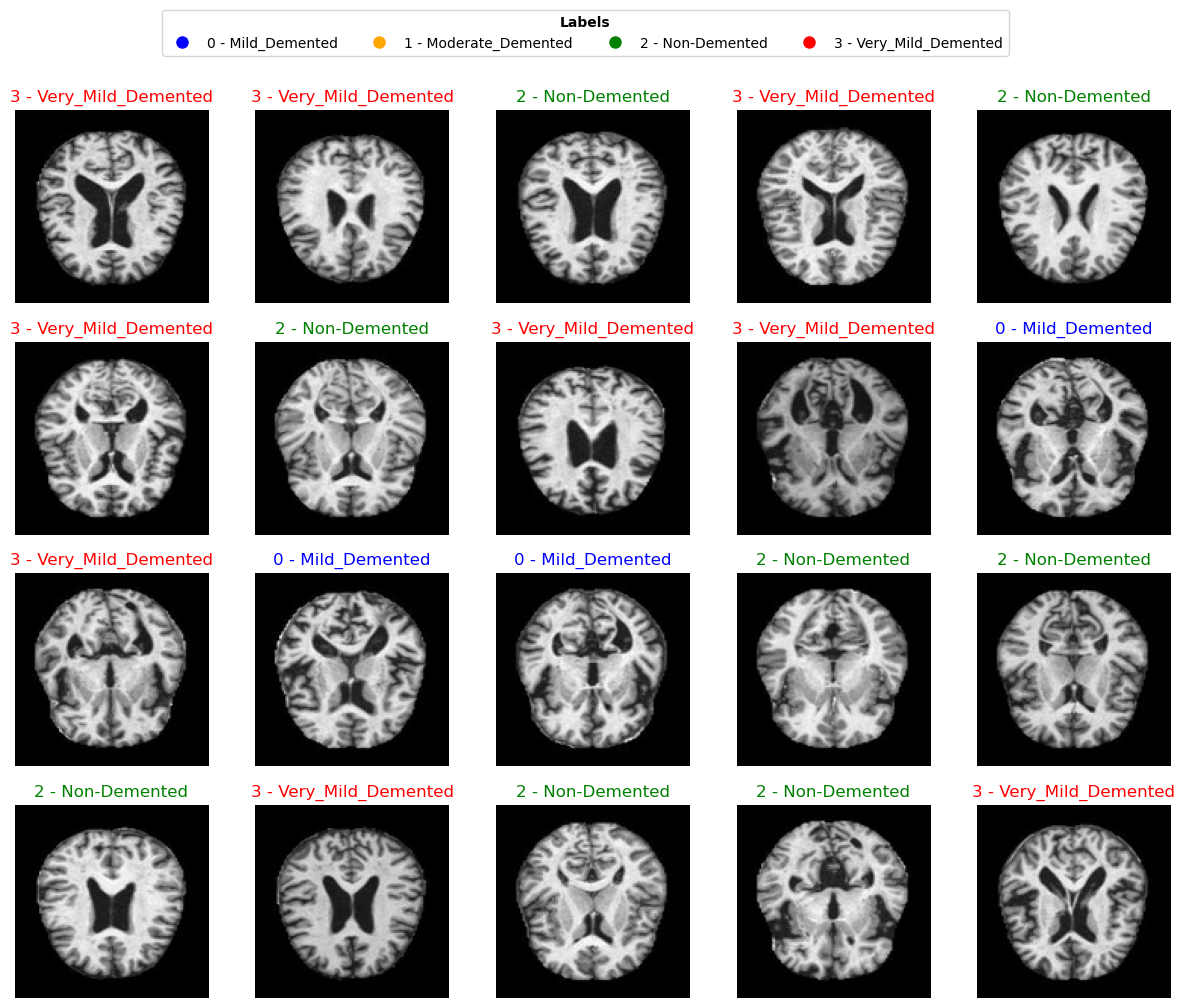

In [5]:
utils_funcs.plot_random_images(train_set,20)

<h1 style="display: flex; align-items: center;">
    <img src="../assets/icons/icons8-kawaii-dinosaur-48.png" style="width: 50px; height: 50px; margin-right: 10px;">
    <strong>DinoV2 Fine Tuned</strong>
</h1>


<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-process-100.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Preprocessing of data
</h1>

In [6]:
width = 224
height = 224

preprocess = transforms.Compose([
    transforms.Resize((width, height)),
    transforms.ToTensor()
])

dino_train_set = utils_funcs.apply_transformations(train_set, preprocess)
dino_validation_set = utils_funcs.apply_transformations(validation_set, preprocess)

dino_validationloader = torch.utils.data.DataLoader(dino_validation_set, batch_size=batch_size, shuffle=True, num_workers=4,pin_memory=True)
# Combine train_set and val_set into one dataset and
dino_combined_train_val_set = ConcatDataset([dino_train_set, dino_validation_set])

# Loading the data and shuffling it
dino_trainloader = torch.utils.data.DataLoader(dino_combined_train_val_set, batch_size=batch_size, shuffle=True, num_workers=4,pin_memory=True)

dino_test_set = utils_funcs.apply_transformations(test_set, preprocess)
dino_testloader = torch.utils.data.DataLoader(dino_test_set, batch_size=batch_size, shuffle=False, num_workers=4,pin_memory=True)

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-data-recovery-40.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Retrieve fined-tuned Model
</h1>

In [7]:
input_channels = 3
output_channels = 4

dino_v2_model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')

# make the model
model = def_models.DINO_v2_FT(dino_backbone=dino_v2_model, output_channels=output_channels).to(device)

# retrieve the fined-tuned model
model_path = './checkpoints/DINO_v2_FT_071907_02102024.pth'
checkpoint = torch.load(model_path,weights_only=True)
model.load_state_dict(checkpoint['net'])

Using cache found in C:\Users\97252/.cache\torch\hub\facebookresearch_dinov2_main


<All keys matched successfully>

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-statistics-64.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Architecture statistics
</h1>

In [8]:
# model statistics
model_name = type(model).__name__
print("model ", model_name," statistics")
summary(model, (input_channels, height, width))

model  DINO_v2_FT  statistics
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 384, 16, 16]         226,176
          Identity-2             [-1, 256, 384]               0
        PatchEmbed-3             [-1, 256, 384]               0
         LayerNorm-4             [-1, 257, 384]             768
            Linear-5            [-1, 257, 1152]         443,520
            Linear-6             [-1, 257, 384]         147,840
           Dropout-7             [-1, 257, 384]               0
   MemEffAttention-8             [-1, 257, 384]               0
        LayerScale-9             [-1, 257, 384]               0
        LayerNorm-10             [-1, 257, 384]             768
           Linear-11            [-1, 257, 1536]         591,360
             GELU-12            [-1, 257, 1536]               0
          Dropout-13            [-1, 257, 1536]               0
         

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-matrix-60.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Confusion Matrix
</h1>

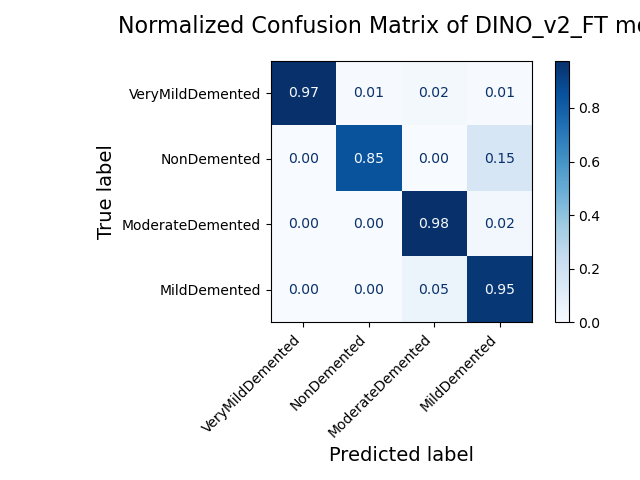

In [9]:
utils_funcs.load_and_display_image(model_name,'confusion_matrix')

**Visualize T-SNE**

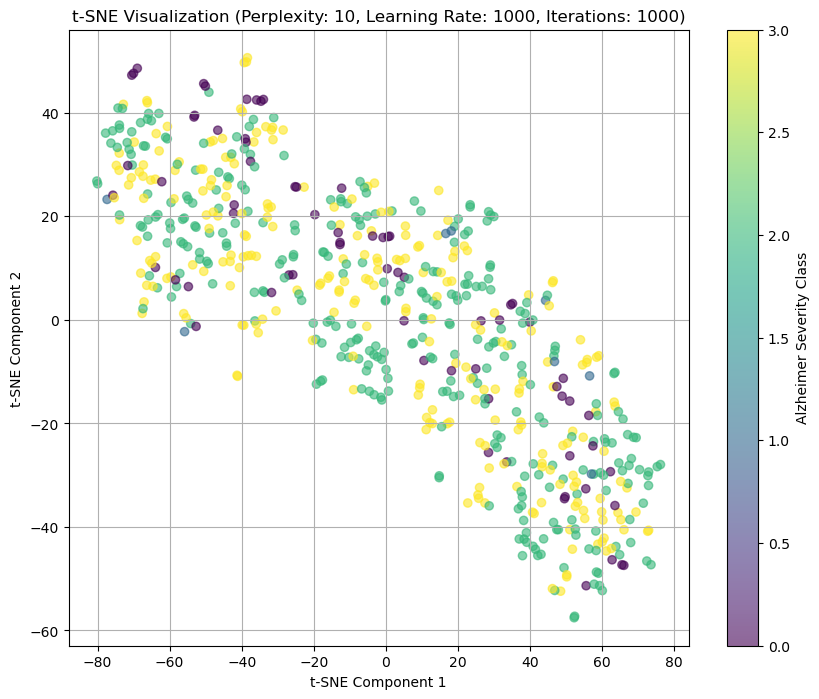

In [17]:
utils_funcs.visualize_dino_tsne(model.dino_backbone, dino_validationloader, device, perplexity=10, learning_rate=1000)
#TODO: make it so we only need to bring the image here

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-graph-80.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Training Curve of the best fined-tuned model
</h1>

In [11]:
# epoch_losses = checkpoint.get('epoch_losses')
# num_epochs = checkpoint.get('epoch')

# utils_funcs.plot_loss_curve(epoch_losses, num_epochs)

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-accuracy-64.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Accuracy
</h1>

In [12]:
test_accuracy = utils_funcs.calculate_accuracy(model, dino_testloader, device)
print("Test accuracy: {:.3f}%".format(test_accuracy))

Test accuracy: 96.172%


<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-source-64.png" style="width: 40px; height: 40px; margin-right: 5px;">
    GradCAM
</h1>

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-weapon-48.png" style="width: 40px; height: 40px; margin-right: 5px;">
    DinoV2 under attack - FGSM,PGD
</h1>

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-graph-80.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Adversial Training Curve
</h1>

<h1 style="display: flex; align-items: center;">
    <img src="../assets/icons/deep-learning.png" style="width: 50px; height: 50px; margin-right: 10px;">
    <strong>Model2 Fine Tuned</strong>
</h1>

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-process-100.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Preprocessing of data
</h1>

In [13]:
# width = 224
# height = 224

# preprocess = transforms.Compose([
#     transforms.Resize((width, height)),
#     transforms.ToTensor()
# ])

# dino_test_set = utils_funcs.apply_transformations(test_set, preprocess)
# dino_testloader = torch.utils.data.DataLoader(dino_test_set, batch_size=batch_size, shuffle=False, num_workers=4,pin_memory=True)

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-data-recovery-40.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Retrieve fined-tuned Model
</h1>

In [14]:
# input_channels = 3
# output_channels = 4

# dino_v2_model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')

# # make the model
# model = def_models.DINO_v2_FT(dino_backbone=dino_v2_model, output_channels=output_channels).to(device)

# # retrieve the fined-tuned model
# model_path = './checkpoints/DINO_v2_FT_070051_02102024.pth'
# checkpoint = torch.load(model_path,weights_only=True)
# model.load_state_dict(checkpoint['net'])

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-statistics-64.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Architecture statistics
</h1>

In [15]:
# # model statistics
# model_name = type(model).__name__
# print("model ", model_name," statistics")
# summary(model, (input_channels, height, width))

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-matrix-60.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Confusion Matrix
</h1>

In [16]:
# utils_funcs.load_and_display_image(model_name,'confusion_matrix')

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-graph-80.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Training Curve of the best fined-tuned model
</h1>

In [17]:
# epoch_losses = checkpoint.get('epoch_losses')
# num_epochs = checkpoint.get('epoch')

# utils_funcs.plot_loss_curve(epoch_losses, num_epochs)

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-accuracy-64.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Accuracy
</h1>

In [18]:
# test_accuracy = utils_funcs.calculate_accuracy(model, dino_testloader, device)
# print("Test accuracy: {:.3f}%".format(test_accuracy))

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-source-64.png" style="width: 40px; height: 40px; margin-right: 5px;">
    GradCAM
</h1>

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-weapon-48.png" style="width: 40px; height: 40px; margin-right: 5px;">
    DinoV2 under attack - FGSM,PGD
</h1>

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-graph-80.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Adversial Training Curve
</h1>

<h1 style="display: flex; align-items: center;">
    <img src="../assets/icons/deep-learning_2.png" style="width: 50px; height: 50px; margin-right: 10px;">
    <strong>Model3 Fine Tuned</strong>
</h1>